In [1]:
import numpy as np
import scipy.linalg
import nengo
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [2]:
# This code has been adapted from nengolib; https://github.com/arvoelke/nengolib

def make_delay_network(q, theta):
    Q = np.arange(q, dtype=np.float64)
    R = (2 * Q + 1)[:, None] / theta
    j, i = np.meshgrid(Q, Q)
    A = np.where(i < j, -1, (-1.)**(i - j + 1)) * R
    B = (-1.)**Q[:, None] * R
    return A, B


def discretize_lti(dt, A, B):
    import scipy.linalg
    Ad = scipy.linalg.expm(A * dt)
    Bd = np.dot(np.dot(np.linalg.inv(A), (Ad - np.eye(A.shape[0]))), B)
    return Ad, Bd

def make_nef_lti(tau, A, B):
    AH = tau * A + np.eye(A.shape[0])
    BH = tau * B
    return AH, BH

In [3]:
class Legendre(nengo.Process):
    def __init__(self, theta, q):
        self.q = q
        self.theta = theta
        self.A, self.B = make_delay_network(self.q, self.theta)
        super().__init__(default_size_in=1, default_size_out=q)

    def make_step(self, shape_in, shape_out, dt, rng, state=None):
        state = np.zeros(self.q)
        Ad, Bd = discretize_lti(dt, self.A, self.B)

        def step_legendre(t, x, state=state):
            state[:] = np.dot(Ad, state) + np.dot(Bd, x)
            return state

        return step_legendre

    def decoder(self, thetap):
        return np.array([
            np.atleast_1d(np.polynomial.Legendre([0] * i + [1], [0, 1])(np.array(thetap))) for i in range(self.q)
        ])

In [4]:
def simulate_delay_network(stim, T=5.0, dt=1e-3, theta=1.0, q=12):
    np.random.seed(4581)
    with nengo.Network() as model:
        nd_stim = nengo.Node(stim)
        nd_legendre = nengo.Node(Legendre(theta, q))

        nengo.Connection(nd_stim, nd_legendre)

        p_stim = nengo.Probe(nd_stim, synapse=None)
        p_legendre = nengo.Probe(nd_legendre, synapse=None)

    with nengo.Simulator(model, dt=dt) as sim:
        sim.run(T)

    ts = sim.trange()
    us = sim.data[p_stim]
    xs = sim.data[p_legendre]

    return ts, us, xs

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

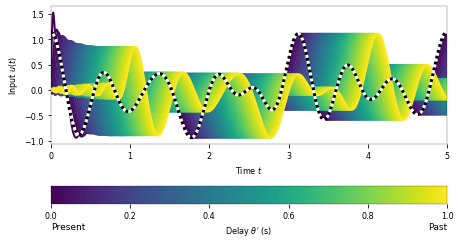

In [5]:
T, theta, q = 5.0, 1.0, 12
ts, us, xs = simulate_delay_network(
    nengo.processes.WhiteSignal(period=T, high=2.0, rms=0.5),
    T=T, theta=theta, q=q)

fig = plt.figure(figsize=(6.5, 3.5))

ax = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
cmap = cm.get_cmap('viridis')
for thetap in np.linspace(0, 1, 50):
    ax.plot(ts, xs @ Legendre(theta, q).decoder(thetap), color=cmap(thetap), linewidth=2)

ax.plot(ts, us, 'black', linestyle=(0, (1, 1)), linewidth=3)
ax.plot(ts, us, 'white', linestyle=(1, (1, 1)), linewidth=3)
ax.set_xlabel('Time $t$')
ax.set_ylabel('Input $u(t)$')
ax.set_xlim(0, T)

cax = plt.subplot2grid((4, 1), (3, 0))
fig.colorbar(cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0, vmax=1, clip=False), cmap=cmap), cax=cax, orientation='horizontal')
cax.set_xlabel('Delay $\\theta\'$ (s)')

fig.tight_layout()

cax.text(0, -1.4, 'Present', fontsize=9)
cax.text(1, -1.4, 'Past', ha='right', fontsize=9)

fig.savefig('../delay_network_decoding.pdf')

In [33]:
def make_decoder_plots(name, stim, qs, thetas):
    T, theta, q = 4.0, 1.0, 12
    ts, us, xs = simulate_delay_network(stim, T=T, theta=theta, q=q)

    for maxq in qs:
        fig = plt.figure(figsize=(6.5, 3.5))
        ax3 = plt.subplot2grid((5, 1), (3, 0), rowspan=2)
        ax2 = plt.subplot2grid((5, 1), (1, 0), rowspan=2, sharex=ax3)
        ax1 = plt.subplot2grid((5, 1), (0, 0), rowspan=1, sharex=ax3)

        ax1.plot(ts, us, 'black', linestyle=(0, (1, 1)), linewidth=3)
        ax1.plot(ts, us, 'white', linestyle=(1, (1, 1)), linewidth=3)
        ax1.set_xlim(0, T)
        ax1.set_ylim(-1.5, 1.5)
        ax1.set_ylabel('$u(t)$')

        for i in range(maxq):
            ax2.plot(ts, xs[:, i], label="$x_{}(t)$".format(i) if i <= 8 else None, linewidth=2)
        ax2.set_xlim(0, T)
        ax2.set_ylim(-1.5, 1.5)
        ax2.set_ylabel('State $\\vec x(t)$')
        ax2.legend(
            ncol=q,
            handlelength=1.0,
            handletextpad=0.25,
            columnspacing=1.0,
        )

        cmap = cm.get_cmap('viridis')
        for thetap in thetas:
            ax3.plot(ts, xs[:, :maxq] @ Legendre(theta, maxq).decoder(thetap), color=cmap(1.0 - thetap),
                     linewidth=2, label="$\\theta' = {:1.1f}$".format(thetap))
        ax3.plot(ts, us, 'black', linestyle=(0, (1, 1)), linewidth=1, label="$u(t)$")
        ax3.set_xlim(0, T)
        ax3.set_ylim(-1.5, 1.5)
        ax3.set_xlabel('Time $t$')
        ax3.set_ylabel('Decoded $u(t - \\theta\')$')
        ax3.legend(
            ncol=q,
            handlelength=1.0,
            handletextpad=0.25,
            columnspacing=1.0,
        )

        for ax in [ax1, ax2]:
            plt.setp(ax.get_xticklabels(), visible=False)

        fig.tight_layout()
        fig.savefig('../{}_q{}.pdf'.format(name, maxq))

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

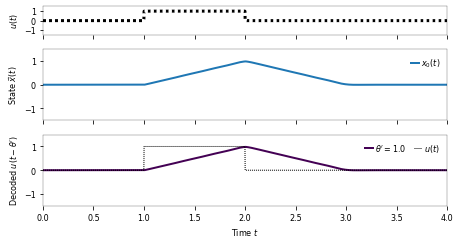

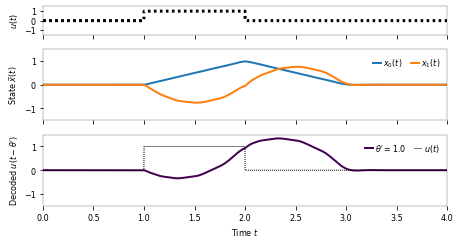

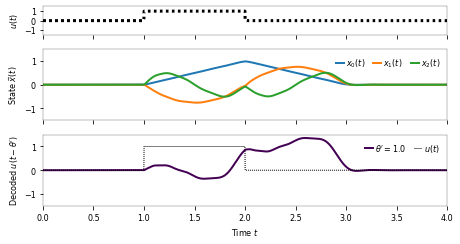

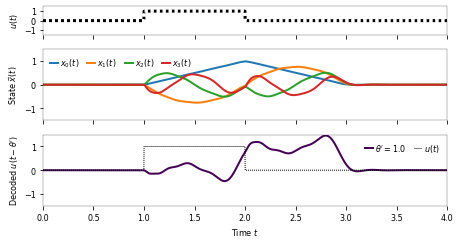

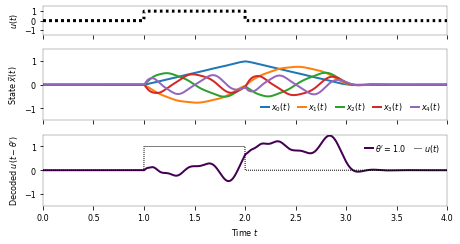

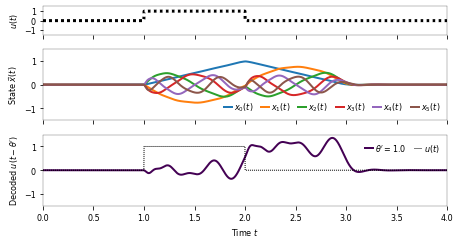

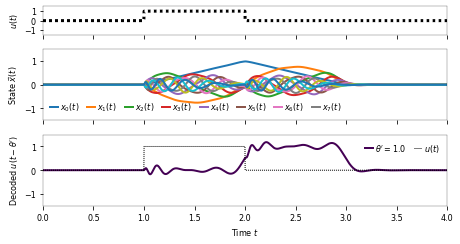

In [34]:
make_decoder_plots('delay_network_step', 
        nengo.processes.Piecewise({
            1.0: 1.0,
            2.0: 0.0,
        }), [1, 2, 3, 4, 5, 6, 11], [1.0])

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

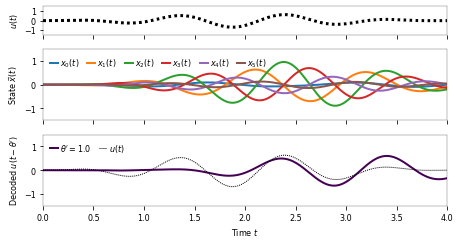

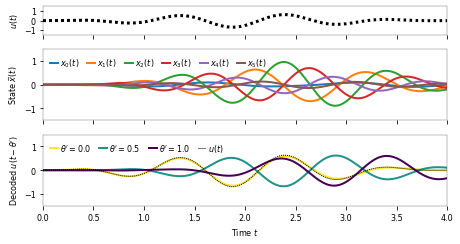

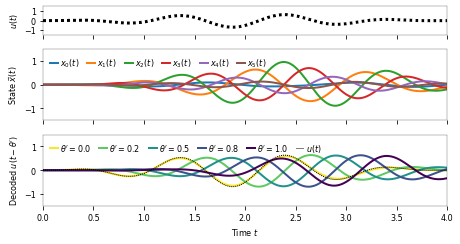

In [35]:
for i, thetas in enumerate([[1.0], [0.0, 0.5, 1.0], [0.0, 0.25, 0.5, 0.75, 1.0]]):
    make_decoder_plots('delay_network_sine_i{}'.format(i), 
        lambda t: 0.7 * (0.5 * (1-np.cos(0.5 * np.pi * t))) * np.sin(1.87 * np.pi * t),
                   [6], thetas)